In [1]:
! pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d moazeldsokyx/dogs-vs-cats

 98% 801M/817M [00:09<00:00, 115MB/s]
100% 817M/817M [00:09<00:00, 88.7MB/s]


In [5]:
from zipfile import ZipFile
dataset='/content/dogs-vs-cats.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
print("extraction done")

extraction done


In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=64
BATCH_SIZE=4
CHANNELS=3

In [22]:
train=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
test=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/test",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
valid=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/validation",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20000 files belonging to 2 classes.
Found 12461 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [23]:
class_names=train.class_names
class_names

['cats', 'dogs']

In [24]:
train_ds=train
test_ds=test
val_ds=valid

In [25]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (4, 64, 64, 3)            0         
                                                                 
 conv2d_4 (Conv2D)           (4, 62, 62, 32)           896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (4, 31, 31, 32)           0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (4, 29, 29, 64)           18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (4, 14, 14, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (4, 12, 12, 64)          

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
5000/5000 [==============================] - 145s 29ms/step - loss: 0.5478 - accuracy: 0.7244 - val_loss: 0.5558 - val_accuracy: 0.7144
Epoch 2/5
5000/5000 [==============================] - 144s 29ms/step - loss: 0.5422 - accuracy: 0.7266 - val_loss: 0.5491 - val_accuracy: 0.7146
Epoch 3/5
5000/5000 [==============================] - 144s 29ms/step - loss: 0.5358 - accuracy: 0.7355 - val_loss: 0.5239 - val_accuracy: 0.7428
Epoch 4/5
5000/5000 [==============================] - 144s 29ms/step - loss: 0.5327 - accuracy: 0.7360 - val_loss: 0.5310 - val_accuracy: 0.7408
Epoch 5/5
5000/5000 [==============================] - 144s 29ms/step - loss: 0.5334 - accuracy: 0.7363 - val_loss: 0.5291 - val_accuracy: 0.7352


In [35]:
scores = model.evaluate(test_ds)
scores

3116/3116 [==============================] - 43s 12ms/step - loss: 0.5175 - accuracy: 0.7375


[0.5174768567085266, 0.7375010251998901]

In [36]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 5000}

In [40]:
import numpy as np

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


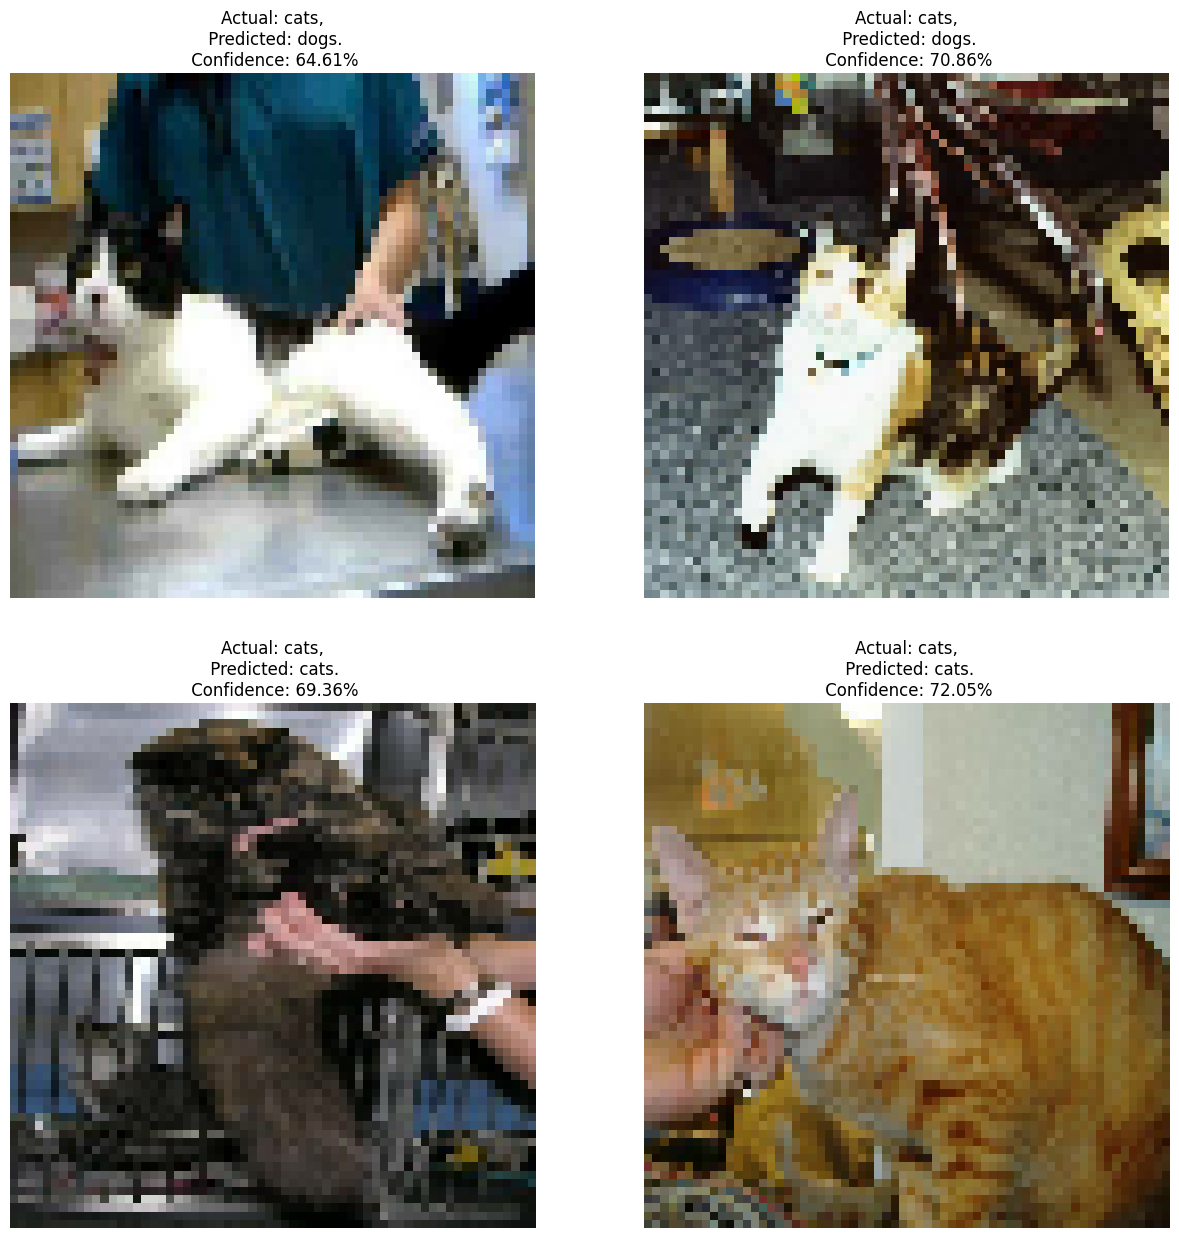

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [42]:
model.save("./dogvscat.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
